In [27]:
## Imports
import random
import json
import torch

from classes import  CIFAKE_loader, CIFAKE_CNN
from test import test_model, score_preds
from train import get_files, train


torch.manual_seed(11)
random.seed(11)

with open('./config.json') as f:
    config = json.load(f)

model_path = config['model']
src_dir = config['CIFAKE_dir']  # https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data, Dec 11, 14:05

### Load data

In [100]:
# load data
data = get_files(src_dir)
trainfiles = data['train'][:int(len(data['train'])*0.975)]
devfiles = data['train'][int(len(data['train'])*0.975):]
testfiles = data['test']
trainfiles[0]  # tuple of filepath + class as str
type(trainfiles)

list

In [101]:
# plot example pre/post normalise; cf tutorial code
# import matplotlib.pyplot as plt
# plt.imshow(np.array(Image.open(a.data[0][0])))  #normal img
# c = transform(Image.open(a.data[0][0]))  # post transform & re-normalise,,kind of
# c = c / 2 + 0.5     # unnormalize
# npimg = c.numpy()
# plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.show()


In [102]:
traindata = CIFAKE_loader(trainfiles, batch_size=32)
devdata =  CIFAKE_loader(devfiles, batch_size=32)

In [103]:
len(devdata)

2500

## Training

Base from AICS course cifar10_tutorial.ipynb

CNN+Linear layers with maxpooling  
Conv2d(3, 6, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Conv2d(6, 16, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Flatten(),  
Linear(16 * 5 * 5, 120),  
ReLU(),  
Linear(120, 84),  
ReLU(),  
Linear(84, 10)  
Sigmoid()  

In [104]:
model = CIFAKE_CNN()

# model = train(model, traindata, epochs=10)
#epoch: 0	total loss: 3117.363366410136	avg loss: 0.5611815241062351
#epoch: 1	total loss: 2005.8685185052454	avg loss: 0.3610924425752017
# https://github.com/changzy00/pytorch-attention/tree/master

In [105]:
# torch.save(model.state_dict(), config['model'])

In [106]:
#?#https://github.com/EvgenyKashin/SRMnet/tree/master/models
import torch
from torch import nn
# https://github.com/changzy00/pytorch-attention/blob/master/attention_mechanisms/srm.py
# official sem : https://github.com/hyunjaelee410/style-based-recalibration-module/blob/master/models/resnet.py
# https://blog.paperspace.com/srm-channel-attention/


class SRMLayer(nn.Module):
    def __init__(self, channel, reduction=None):
        # Reduction for compatibility with layer_block interface
        super(SRMLayer, self).__init__()

        # CFC: channel-wise fully connected layer
        self.cfc = nn.Conv1d(channel, channel, kernel_size=2, bias=False,
                             groups=channel)
        self.bn = nn.BatchNorm1d(channel)

    def forward(self, x):
        b, c, _, _ = x.size()

        # Style pooling
        mean = x.view(b, c, -1).mean(-1).unsqueeze(-1)
        std = x.view(b, c, -1).std(-1).unsqueeze(-1)
        u = torch.cat((mean, std), -1)  # (b, c, 2)

        # Style integration
        z = self.cfc(u)  # (b, c, 1)
        z = self.bn(z)
        g = torch.sigmoid(z)
        g = g.view(b, c, 1, 1)

        return x * g.expand_as(x)

import torch.nn.functional as F

class CIFAKE_CNN(nn.Module):
    # from cifar10_tutorial.ipynb; so far only chaned fc3 final dim to 1
    # for binary classification + added Sigmoid
    def __init__(self):
        super().__init__()
        ## unroll to visualise used structure from class
        # self.net = nn.Sequential(
        #     nn.Conv2d(3, 6, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #      nn.Conv2d(6, 16, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #      nn.Flatten(),
        #     nn.Linear(16 * 5 * 5, 120),
        #     nn.ReLU(),
        #     nn.Linear(120, 84),
        #     nn.ReLU(),
        #      nn.Linear(84, 10))

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.attend = SRMLayer(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        #  out = self.net(x)
        x = self.pool(F.relu(self.conv1(x)))
      #  x = self.attend(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [107]:

import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score



def acc_fcn(model, thresh=0.5):
    gold, preds = list(), list()
    n_batches = len(devdata)//devdata.batch_size
    with torch.no_grad():
        for batch in devdata:
            X, y_true = batch
            # calculate outputs by running images through the network
            output = model(X).squeeze()
            # Store true and predicted class labels
            gold.extend(list(np.array(y_true)))
            preds.extend(list(np.array(output)))
    y_pred = [1 if pred >= thresh else 0 for pred in preds]
    acc = accuracy_score(gold, y_pred)

    return acc



def trainz(model: CIFAKE_CNN, data: list[tuple], epochs: int = 5,
          learn_rate: float = 0.001, momentum: float = 0.9) -> CIFAKE_CNN:
    """Train and return CNN for binary image classification.

    Args:
        model (CIFAKE_CNN): CNN model structure
        data (list[tuple]): List of (filename, class label) items as str
        epochs (int, optional): Number of epochs. Defaults to 5.
        learn_rate (float, optional): Optimizer learn rate. Defaults to 0.001.
        momentum (float, optional): Momentum for optimizer. Defaults to 0.9.

    Returns:
        CIFAKE_CNN: CNN model for binary image classification
    """
    # own function, structure base from cifar10_tutorial.ipynb, but modified
    # everthing but the running_loss usage
    criterion = nn.BCELoss()  # match loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
    n_batches=len(data)//data.batch_size  # determine nr of batches for pretty tqdm

    accs = dict()
    for epoch in range(epochs):
        total_loss = 0 #change to dict, start logging, 
        running_loss = 0
        for i, batch in tqdm(enumerate(data), total=n_batches):
            # reset gradient
            optimizer.zero_grad()

            accs[i]  = acc_fcn(model)

            # Extract input and labels, make predictions
            X, y = batch
            output = model(X)


            # calculate & store loss
            loss = criterion(output, y.reshape(-1, 1))  # reshape for single dim
            running_loss += loss.item()
            total_loss += loss.item()

            # backpropagate & update gradient
            loss.backward()
            optimizer.step()

            # print statistics
            if i % (n_batches//4) == (n_batches//4)-1:
                print(f'[{epoch+1}, {i+1:5d}] avg loss: {running_loss/(n_batches//4):.3f}',
                      end='\r')  # kept from class notebook, udpated with n_batches
                running_loss = 0.0

        print(f'\repoch: {epoch}\ttotal loss: {total_loss}\tavg loss: {total_loss/n_batches}')
        break
    print('Finished Training')

    return model, accs


In [ ]:

model = CIFAKE_CNN()
model, accs = trainz(model, traindata, epochs=1)


  0%|          | 0/3046 [00:00<?, ?it/s]

415 [('../data/CIFAKE/train/REAL/3231 (7).jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/5972 (5).jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/1632.jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/1379 (8).jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/4519 (9).jpg', 'REAL'), ('../data/CIFAKE/train/REAL/0159.jpg', 'REAL'), ('../data/CIFAKE/train/REAL/1973 (6).jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/4156 (8).jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/4650 (7).jpg', 'REAL'), ('../data/CIFAKE/train/REAL/3996.jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/2638 (6).jpg', 'FAKE'), ('../data/CIFAKE/train/FAKE/1077.jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/2166 (3).jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/2535 (4).jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/0594 (5).jpg', 'REAL'), ('../data/CIFAKE/train/REAL/2698 (6).jpg', 'REAL'), ('../data/CIFAKE/train/REAL/1915 (8).jpg', 'REAL'), ('../data/CIFAKE/train/FAKE/4943 (10).jpg', 'FAKE'), ('../data/CIFAKE/train/REAL/4162 (4).jpg', 'REAL'), ('../data/CIFAKE/train

In [83]:
accs

{0: 0.44443456614509247}

In [43]:
#https://github.com/EvgenyKashin/SRMnet/tree/master/models

## Testing

In [66]:
# load data
testdata = CIFAKE_loader(testfiles, batch_size=18)

  0%|          | 0/1111 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

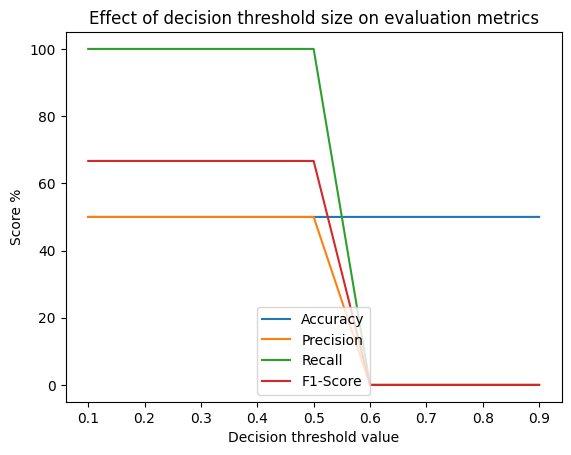

In [67]:
# mini train 
mini_gold, mini_preds = test_model(model, testdata)
mini_thresh_data = {}
for i in range(1, 10):
    thresh = round(i/10, 2)
    mini_thresh_data[thresh] = {metric: score_preds(mini_gold, mini_preds, thresh=thresh)[i]
                           for i, metric in enumerate(['Accuracy', 'Precision',
                                                       'Recall', 'F1-Score'])}
import pandas as pd
import matplotlib.pyplot as plt

mini_df = pd.DataFrame(mini_thresh_data.values(), index=mini_thresh_data.keys()).mul(100)
fig = mini_df.plot()

fig.set_ylabel('Score %')
fig.set_xlabel('Decision threshold value')
fig.title.set_text('Effect of decision threshold size on evaluation metrics')
fig.legend(loc='lower center')
plt.show()

In [68]:
mini_df

,Accuracy,Precision,Recall,F1-Score
0.1,49.994999,49.994999,100.0,66.662222
0.2,49.994999,49.994999,100.0,66.662222
0.3,49.994999,49.994999,100.0,66.662222
0.4,49.994999,49.994999,100.0,66.662222
0.5,49.994999,49.994999,100.0,66.662222
0.6,50.005001,0.000000,0.0,0.000000
0.7,50.005001,0.000000,0.0,0.000000
0.8,50.005001,0.000000,0.0,0.000000
0.9,50.005001,0.000000,0.0,0.000000


In [58]:
# # load model
# model = CIFAKE_CNN()
# model.load_state_dict(torch.load(config['model']))

In [59]:
# predict labels & evaluate with accuracy, precision, recall, f1-score
gold, preds = test_model(model, testdata)

  0%|          | 0/1111 [00:00<?, ?it/s]

In [60]:
thresh_data = {}
for i in range(1, 10):
    thresh = round(i/10, 2)
    thresh_data[thresh] = {metric: score_preds(gold, preds, thresh=thresh)[i]
                           for i, metric in enumerate(['Accuracy', 'Precision',
                                                       'Recall', 'F1-Score'])}

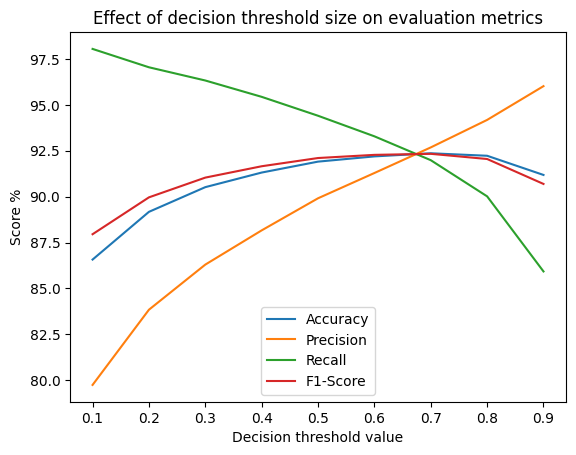

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(thresh_data.values(), index=thresh_data.keys()).mul(100)
fig = df.plot()

fig.set_ylabel('Score %')
fig.set_xlabel('Decision threshold value')
fig.title.set_text('Effect of decision threshold size on evaluation metrics')
fig.legend(loc='lower center')
plt.show()

In [62]:
df

,Accuracy,Precision,Recall,F1-Score
0.1,86.573657,79.744570,98.049610,87.954780
0.2,89.173917,83.841701,97.049410,89.963377
0.3,90.519052,86.299283,96.329266,91.038851
0.4,91.314131,88.164095,95.439088,91.657461
0.5,91.909191,89.912364,94.408882,92.105777
0.6,92.194219,91.289028,93.288658,92.278011
0.7,92.364236,92.683664,91.988398,92.334722
0.8,92.229223,94.181666,90.018004,92.052777
0.9,91.184118,96.021013,85.927185,90.694115


In [ ]:
# plot trainig acc vs val accuracy vs loss...